In [167]:
import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Description des étapes :
* Chargement des données d'entrainement
* Prise de connaissance des données : target, différents champs, signification, types, valeurs manquantes, etc...
* Définition d'un premier modèle quick and dirty pour établir un niveau 0
    * Définition d'un mode de validation du modèle (type de cross-validation)
    * Test sur un modèle simple.Ex: régression logistique
    * Définition du score de référence (niveau 0) à battre
* Etude de la distribution des varialbes
* Ajout d'une variable discrimintante : la classe (Pclass)
* Nouveau modèle avec les variables Age & Sex
* Custom de la variable Age (feature engineering) :
    * Forte survie chez les personnes de moins de 8 ans => création de la variable is_child
* Introduction d'un modèle non linéaire plus adapté : le Random Forest

# Chargement des données d'entrainement :

In [168]:
train = pd.read_csv('data/train.csv',sep=',')
train = train.set_index('PassengerId', drop=True)

In [169]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Premier modèle quick and dirty :
On va seulement utiliser les variables numériques continues directement exploitables (sans valeurs manquantes) : Fare, SibSp, Parch

In [170]:
def parse_model_0(X):
    target = X['Survived']
    X = X[['Fare', 'SibSp', 'Parch']]
    return X,target

In [171]:
X,y = parse_model_0(train.copy())

In [172]:
from sklearn.model_selection import cross_val_score
def compute_score(clf,X,y):
    xval = cross_val_score(clf,X,y,cv=5)
    return xval.mean()

## Test d'une régression logistique simple :

In [173]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
compute_score(lr,X,y)

0.6746092524009792

=> Premier benchmark à 0.67, qui devient le score à battre !

In [174]:
survived = train[train.Survived == 1]
dead = train[train.Survived == 0]

# Distribution de la variable Pclass :

In [175]:
def plot_hist(feature, bins = 20):
    x1 = dead[feature].dropna()#.array
    x2 = survived[feature].dropna()#.array
    plt.hist([x1,x2], label=['Victime','Survivant'], bins=bins)
    plt.legend(loc = 'upper left')
    plt.title('distribution relative de %s' %feature)
    plt.show()

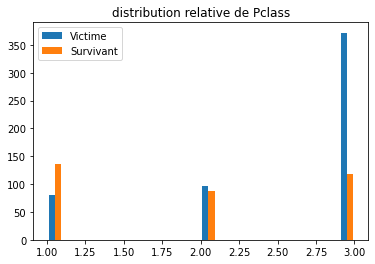

In [176]:
plot_hist('Pclass')

2 conclusions rapides :
* La plupart des victimes étaient en 3ème classe
* Les survivants proviennent plutôt de la 1ère classe

# Ajout de la variable Pclass au modèle :
Variable catégorielle => get_dummies

In [194]:
def parse_model_1(X):
    target = X.Survived
    class_dummies = pd.get_dummies(X['Pclass'],prefix='split_Pclass')
    X = X.join(class_dummies)
    to_del = ['Name', 'Age', 'Cabin', 'Embarked', 'Survived', 'Ticket', 'Sex', 'Pclass']
    for _ in to_del: del X[_]
    return X, target

In [195]:
X,y = parse_model_1(train.copy())

In [196]:
lr = LogisticRegression()
compute_score(lr,X,y)

C:\Users\33786\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6937040989266211

=> + 2% (pas dégueu en soi)

Poids des variables :

In [198]:
def display_poids_variables(X,y,title='title'):
    lr = LogisticRegression()
    lr.fit(X,y)
    coefs = lr.coef_[0]
    columns_train = X.columns

    y_pos = np.arange(len(coefs))

    plt.bar(y_pos, coefs, align='center', alpha=0.5)
    plt.xticks(y_pos, columns_train, rotation=50)
    plt.title(title)

    plt.show()

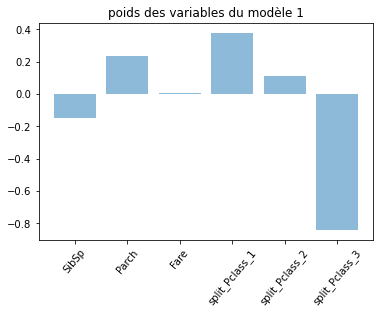

In [199]:
display_poids_variables(X,y,'poids des variables du modèle 1')

# Nouveau modèle :
On s'appuie sur l'adage "Les femmes et les enfants d'abord. Ajout des 2 variables :
* Sex : binarisation
* Age : on remplit les valeurs manquantes avec la médiane

In [200]:
def parse_model_2(X):
    target = X.Survived
    to_dummy = ['Pclass', 'Sex']
    for dum in to_dummy:
        split_temp = pd.get_dummies(X[dum],prefix='split_'+dum)
        for col in split_temp:
            X[col] = split_temp[col]
        del X[dum]
    X['Age'] = X['Age'].fillna(X['Age'].median())
    to_del = ['Name', 'Cabin', 'Embarked', 'Survived', 'Ticket']
    for _ in to_del: del X[_]
    return X, target

In [181]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [201]:
X,y = parse_model_2(train.copy())

In [202]:
lr = LogisticRegression()
compute_score(lr,X,y)

C:\Users\33786\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\33786\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.7867553825874083

In [191]:
X.describe()

,Age,SibSp,Parch,Fare,split_Pclass_1,split_Pclass_2,split_Pclass_3,split_Sex_female,split_Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.361582,0.523008,0.381594,32.204208,0.242424,0.206510,0.551066,0.352413,0.647587
std,13.019697,1.102743,0.806057,49.693429,0.428790,0.405028,0.497665,0.477990,0.477990
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000
75%,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\33786\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


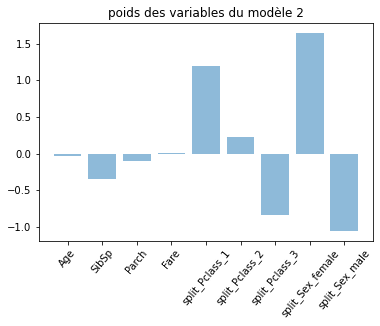

In [203]:
display_poids_variables(X,y,'poids des variables du modèle 2')

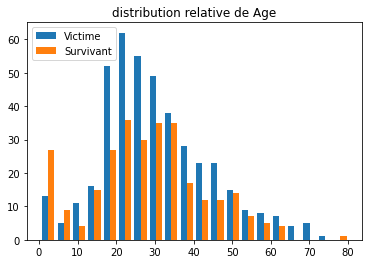

In [204]:
plot_hist('Age')

# Custom de la variable age :

In [216]:
def parse_model_3(X):
    target = X.Survived
    to_dummy = ['Pclass', 'Sex']
    for dum in to_dummy:
        split_temp = pd.get_dummies(X[dum],prefix='split_'+dum)
        for col in split_temp:
            X[col] = split_temp[col]
        del X[dum]
    X['Age'] = X['Age'].fillna(X['Age'].median())
    X['is_child'] = X.Age < 8
    to_del = ['Name', 'Cabin', 'Embarked', 'Survived', 'Ticket', 'Age', 'Fare']
    for _ in to_del: del X[_]
    return X, target

In [217]:
X,y = parse_model_3(train.copy())

In [218]:
lr = LogisticRegression()
compute_score(lr,X,y)

0.8125541397275752

=> On gagne de nouveau 3 points

(Bosté car j'ai viré Age et Fare qui ne servent à rien)

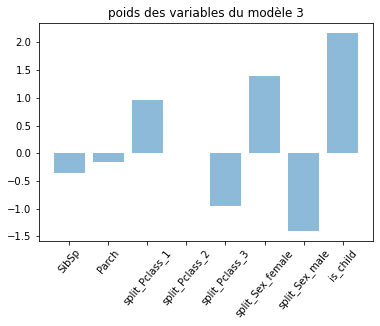

In [219]:
display_poids_variables(X,y,'poids des variables du modèle 3')

# Random Forest :

In [220]:
from sklearn.ensemble import RandomForestClassifier

In [237]:
X,y = parse_model_3(train.copy())
rf = RandomForestClassifier()
compute_score(rf,X,y)

0.808097420124286

=> Score équivalent

In [ ]:
test = pd.read_csv('data/test.csv',sep=',')